# Sugarscape model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time import sleep
from IPython.display import clear_output
import math
import warnings
import statistics

# we change the DPI settings to imporove plot resolution
mpl.rcParams['figure.dpi'] = 150

# here we initiate global variables
exceedance = 0
price_tracker_element = list()

## Environments

### First environment - Poor country

In [ ]:
class Sugarscape_poor():

    def __init__(self, n, **params):
        self.n = n
        self.params = params

        self.capacity = self.make_capacity()    # make the capacity array

        self.array = self.capacity.copy()   # initially all cells are at capacity

        if trades:
            self.capacity_spice= self.make_capacity_spice()
            self.array_spice = self.capacity_spice.copy()

        if emigrate:
            global EMIGRATED_AGENTS
            self.emigrated_agents = EMIGRATED_AGENTS
            self.array_port = self.port()

        self.make_agents()

        if government:
            self.array_dispensaries = self.dispensaries()

    def make_capacity(self):
        """ This creates the array with the values of sugar for each cell when they are full. """

        # calculate the minimum distance from one the two peaks of sugar
        X, Y = np.indices((self.n, self.n))
        dist1 = np.hypot(X-14, Y-14)
        dist2 = np.hypot(X-35, Y-35)
        dist = np.minimum(dist1, dist2)

        bins = [11, 8, 5, 2]    # values in the capacity array are set according to dist from peak
        a = np.digitize(dist, bins)

        return a

    def make_capacity_spice(self):
        """ This creates the array with the values of spice for each cell when they are full. """

        #calculate the minimum distance from one the two peaks of spice
        X, Y = np.indices((self.n, self.n))
        dist1 = np.hypot(X-14, Y-35)
        dist2 = np.hypot(X-35, Y-14)
        dist = np.minimum(dist1, dist2)

        bins = [21, 16, 11, 6]  # cells in the capacity array are set according to dist from peak
        a = np.digitize(dist, bins)

        return a

    def make_agents(self):
        """ Creates and places the agents in the grid. """

        n, m = self.array.shape
        if migration:
            n, m = 20, 20
        t = [(i, j) for i in range(n) for j in range(m)]
        locs = np.array(t)
        np.random.shuffle(locs) # all the cell in the grid shuffled

        num_agents = self.params.get('num_agents', 400) # make the number of agents required, the default is 400
        self.agents = [Agent(locs[i], self.params)
                       for i in range(num_agents)]

        self.draw()

        self.occupied = set(agent.loc for agent in self.agents) # keep track of which cells are occupied

    def dispensaries(self):
        """ This sets the location of the government's dispensaries on the map. """
        t = [(i*2+37, j*2+8) for i in range(3) for j in range(3)]
        a = np.array(t)

        t = [(i*2+8, j *2+37) for i in range(3) for j in range(3)]
        b= np.array(t)

        disp = np.vstack((a, b))
        return disp

    def port(self):
        """
        Insert a port in the simulation that lets the agents move to the other environment
        """
        p = [(i+22, 49) for i in range(5)]
        port = np.array(p)
        return port

    def grow(self, totex):
        """
        This function grows back the sugar (and the spice) given the growth rate until it's back at its original capacity.
        """

        grow_rate = 0.3
        self.array_copy = self.array

        # minimum between the actual capacity of the sugar (or spice) plus the growth rate and the max capacity so it doesn't exceed the latter
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        if trades:
            self.array_spice = np.minimum (self.array_spice + grow_rate, self.capacity_spice)

        # replenish dispensaries
        if government:
            disp = self.array_dispensaries
            for i in disp:
                self.array[i[0],i[1]] = self.array_copy[i[0],i[1]] + round(totex/len(disp)) # every dispensary we distribute an equal amount of the exceedance of other agents

                if self.array[i[0],i[1]] > 5:   # we max the dspensaries at 5
                    self.array[i[0],i[1]] = 5


    def look_and_move(self, center, vision):
        """
        This function let's the agent look vertically and horizontally,
        find the cell with the most amount of sugar, and returns that location.
        """

        # this sections creates a shuffled array of the locations that the agent can "see".
        def make_array(d):
            a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
            return a
        arrays = [make_array(d) for d in range(1, vision+1)]
        locs = np.vstack(arrays)
        np.random.shuffle(locs)

        # this makes it possible to forbid negative values
        # and those bigger than 50, changing them in a coherent way
        locs = (locs + center) % self.n
        locs = [tuple(loc) for loc in locs]

        empty_locs = [loc for loc in locs if loc not in self.occupied]

        if len(empty_locs) == 0:    # if all visible cells are occupied, stay put
            return center

        # return the cell with the best sugar levels
        t = [self.array[loc] for loc in empty_locs]
        i = np.argmax(t)
        return empty_locs[i]

    def look_and_move_trade(self, center, vision, metabolism, metabolism_spice, sugar, spice, agent):
        """
        This function let's the agent trade with the nearest neighbour that maximizes wellfare and
        then move the agent in the cell that maximizes wellfare
        """

        # this section is the same of the model without trading
        def make_array(d):
            a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
            return a
        arrays = [make_array(d) for d in range(1, vision+1)]
        locs = np.vstack(arrays)
        np.random.shuffle(locs)
        locs = (locs + center) % self.n
        locs = [tuple(loc) for loc in locs]
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        occupied_locs = [loc for loc in locs if loc in self.occupied]

        # calculate the MRS of the agent based on its wellfare function, endowments of resources and metabolism
        mrs_agent = self.mrs(metabolism, metabolism_spice, sugar, spice)
        wellfare_agent = self.wellfare(metabolism, metabolism_spice, sugar, spice)

        # find available to trade agents (agent_trader) that maximizes the wellfare of the agent that is moving
        # calcuate the mtrs of the possible trader, the price of the trade, and the resulting quantities
        # after trade has take place
        posizioni = [(i, i.loc) for i in self.agents]
        agent_trader = (0,0)
        for i in posizioni:
            for l in occupied_locs:
                if i[1] == l:
                    mrs_agent_trader = self.mrs(i[0].metabolism, i[0].metabolism_spice, i[0].sugar, i[0].spice)
                    price =  math.sqrt(mrs_agent_trader * mrs_agent)
                    wellfare_trader = self.wellfare(i[0].metabolism, i[0].metabolism_spice, i[0].sugar, i[0].spice)
                    person = self.quantities(price, wellfare_trader, wellfare_agent, mrs_agent, mrs_agent_trader,
                                             metabolism, metabolism_spice, sugar, spice,i[0].metabolism, i[0].metabolism_spice,
                                             i[0].sugar, i[0].spice, i)
                    if person:
                        if agent_trader[1] < person[1] :
                            agent_trader = person

        # if we found the trader that maximizes our wellfare we trade
        if agent_trader != (0,0):
            delta_sug = agent_trader[3]
            delta_sp = agent_trader[4]

            agent.sugar += delta_sug
            agent_trader[0].sugar -= delta_sug

            agent.spice += delta_sp
            agent_trader[0].spice -= delta_sp

            # this keeps track of the prices of the transactions
            price_of_trade = agent_trader[5]
            global price_tracker_element
            price_tracker_element.append(price_of_trade)

        # if all visible cells are occupied, the agent stays put and does not move
        if len(empty_locs) == 0:
            return center

        # find the cell that maximizes wellfare so that agent's wellfare is maximized
        # (if there is no cell that maximizes wellfare the agent stays put)
        t = [(self.array[loc],self.array_spice[loc],loc) for loc in empty_locs]
        wellfare_loc = [(self.wellfare(metabolism, metabolism_spice, sugar + element[0]-metabolism, spice + element[1]-metabolism_spice ), element[2]) for element in t ]
        t = [(self.array[loc],self.array_spice[loc],loc) for loc in empty_locs]
        wellfare_loc = [(self.wellfare(metabolism, metabolism_spice, sugar + element[0]-metabolism, spice + element[1]-metabolism_spice ), element[2]) for element in t ]
        location = (0,0)
        for item in wellfare_loc:
            if item[0]>location[0]:
                location = item
        if location[1] == 0:
            return center

        return location[1]

    def harvest(self, loc):
        """ Makes the sugar in which the agent moved equal to 0. """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def harvest_spice(self, loc):
        """ Makes the spice in which the agent moved equal to 0. """
        spice = self.array_spice[loc]
        self.array_spice[loc]=0
        return spice

    def emigrate(self, agent):
        self.agents.remove(agent)
        global EMIGRATED_AGENTS
        EMIGRATED_AGENTS += 1

    def step(self):
        """ This executes one cicle of the movement of the agents and checks if they're still alive. """

        # calculate 80 percentile of sugar wealth and initiates the variable fore the total exceedance
        # (this is for the government model only)
        perc = np.percentile(self.get_sugar(), 90)
        totex=0

        random_order = np.random.permutation(self.agents)
        for agent in random_order:

            try:
                self.occupied.remove(agent.loc)
            except:
                pass

            exceedance = agent.step(self, perc, agent)

            if government:
                totex = totex + exceedance  # tracker of the total exceedance

            if emigrate:
                if agent.loc in self.array_port:    # if the agent is in the port it moves to the other environment
                    self.emigrate(agent)
                    continue

            if agent.is_starving() or agent.is_old():   # if the agent is dead, remove from the list
                self.agents.remove(agent)
            else:
                self.occupied.add(agent.loc)    # otherwise mark its cell occupied

        if emigrate:
            # update the number of agents that emigrated
            global EMIGRATED_AGENTS, NEW_EMIGRATED_AGENTS, NEW_EMIGRATED_LIST
            NEW_EMIGRATED_LIST.append(EMIGRATED_AGENTS - NEW_EMIGRATED_AGENTS)
            NEW_EMIGRATED_AGENTS = EMIGRATED_AGENTS

        self.grow(totex)    # grow back sugar in cells (and dispensaries using the exceedance)

        return len(self.agents)

    def draw(self):
        """ Draws the simulations """

        if trades:
            array_to_draw = np.maximum(self.array, self.array_spice)
            plt.imshow(array_to_draw, cmap='YlOrRd', vmax=9, origin='lower')    # spice and sugar have the same color
        else:
            plt.imshow(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        plt.title("Poor country")
        s = "Number of agents: {}".format(len(self.agents))
        plt.text(x=0, y=-3, s=s, fontsize=12)
        if emigrate:
            global EMIGRATED_AGENTS
            e = "Number of emigrated agents: {}".format(EMIGRATED_AGENTS)
            plt.text(x=0, y=-5, s=e, fontsize=12)

        plt.xticks([])
        plt.yticks([])

        agents = self.agents
        ys, xs = np.transpose([agent.loc for agent in agents])
        plt.plot(xs, ys, '.', color='black')[0]

        if government:
            dispensaries = self.dispensaries()
            ys, xs = np.transpose(dispensaries)
            plt.plot(xs, ys, "x", color='green')[0]

        if emigrate:
            port = self.port()
            ys, xs = np.transpose(port)
            plt.plot(xs, ys, "+", color='blue')[0]

    def animate(self, frames, interval=None, step=None):
        """
        This is the function that keeps the simulation going.
        """
        # interval in seconds between frames #steps between frames

        # getting the stats
        num_agents = [len(self.agents)]
        sug = self.get_sugar()

        # mean of characteristics
        mean_sugar = [np.mean(self.get_sugar())]
        mean_met = [np.mean(self.get_metabolism())]
        mean_vision = [np.mean(self.get_vision())]
        if not trades:
            gini = [self.gini_coeff(sug)]
        else:
            sp = self.get_spice()
            tot = [sum(x) for x in zip(sug, sp)]
            gini = [self.gini_coeff(tot)]
            price_tracker = dict()

            mean_sp = [np.mean(sp)]
            mean_met_sp = [np.mean(self.get_spice_met())]

        if step is None:
            step = self.step
        plt.show()

        # for every cicle call the step function, draw the grid and save the stats
        for i in range(frames-1):
            # getting other stats
            if trades:
                global price_tracker_element
                price_tracker_element = list()

                mean_sp.append(np.mean(sp))
                mean_met_sp.append(np.mean(self.get_spice_met()))

            self.draw() # plots the simulation
            plt.show()

            if interval:
                sleep(interval) # stops the simulation for the seconds specified in the interval
            step() # do the cicle

            num_agents.append(len(self.agents))
            sug = self.get_sugar()

            mean_sugar.append(np.mean(self.get_sugar()))
            mean_met.append(np.mean(self.get_metabolism()))
            mean_vision.append(np.mean(self.get_vision()))

            if not trades:
                gini.append(self.gini_coeff(sug))
            else:
                sp = self.get_spice()
                tot = [sum(x) for x in zip(sug, sp)]
                gini.append(self.gini_coeff(tot))
                price_tracker[i+1] = price_tracker_element

            clear_output(wait=True) # refreshes the plots

        self.draw()
        plt.show()

        # returns the stats
        if trades:
            interests = [num_agents, gini, price_tracker, mean_sugar, mean_met, mean_vision, mean_sp, mean_met_sp]
        else:
            interests = [num_agents, gini, mean_sugar, mean_met, mean_vision]
        return (interests)

    def get_vision(self):
        """ Returns a list with the vision of all the agents in that moment. """
        return [agent.vision for agent in self.agents]

    def get_metabolism(self):
        """ Returns a list with the metabolism of all the agents in that moment. """
        return [agent.metabolism for agent in self.agents]

    def get_lifespan(self):
        """ Returns a list with the lifespan of all the agents in that moment. """
        return [agent.lifespan for agent in self.agents]

    def get_sugar(self):
        """ Returns a list with the sugar of all the agents in that moment. """
        return [agent.sugar for agent in self.agents]

    def get_spice(self):
        """ Returns a list with the spices of all the agents in that moment. """
        return [agent.spice for agent in self.agents]

    def get_spice_met(self):
        """ Returns a list with the spices of all the agents in that moment. """
        return [agent.metabolism_spice for agent in self.agents]

    def gini_coeff(self, arr):
        x = np.array(arr)
        total = 0
        for i, xi in enumerate(x[:-1], 1):
            total += np.sum(np.abs(xi - x[i:]))
        return total / (len(x)**2 * np.mean(x))

    def mrs(self, metabolism, metabolism_spice, sugar, spice):
        return (spice / metabolism_spice) / (sugar / metabolism)

    def wellfare(self, met, met_sp, sug, spices):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            wellfare = (sug**(met/ (met + met_sp))) * (spices**(met_sp / (met + met_sp)))
        return wellfare

    def quantities(self, price, well_trad, well_agent, mrs_agent, mrs_poss_trader, ag_met, ag_met_s, ag_sug, ag_sp, tr_met, tr_met_s, tr_sug, tr_sp, i):
        """ Receives characteristics and returns the outcome of the exchange if it is vantagious for both parties. """
        if mrs_agent >= mrs_poss_trader:
            #agent buys sugar, poss_trad buys spice
            if price > 1:
                change_sug_ag = 1
                change_sp_ag = -price
                #agent exchanges p units of spice for 1 unit of sugar
                ag_sp -= price
                tr_sp += price
                ag_sug += 1
                tr_sug -= 1
            else:
                change_sug_ag = 1/price
                change_sp_ag = -1
                #agent exchanges 1 unit of spice for 1/p unit of sugar
                ag_sp -= 1
                tr_sp += 1
                ag_sug += 1/price
                tr_sug -= 1/price
        else:
            #agent buys spice, poss_trad buys sugar
            if price >= 1:
                change_sug_ag = -1
                change_sp_ag = price
                #agent exchanges 1 units of sugar for p unit of spice
                ag_sp += price
                tr_sp -= price
                ag_sug -= 1
                tr_sug += 1
            else:
                change_sug_ag = -1/price
                change_sp_ag = +1
                #agent exchanges 1/p units of sugar for 1 unit of spice
                ag_sp += 1
                tr_sp -= 1
                ag_sug -= 1/price
                tr_sug += 1/price

        #calculate the new levels of wellfare
        wellfare_agent = self.wellfare(ag_met, ag_met_s, ag_sug, ag_sp)
        wellfare_trader = self.wellfare(tr_met, tr_met_s, tr_sug, tr_sp)

        if wellfare_agent >= well_agent and wellfare_trader > well_trad:
            agent=(i[0], wellfare_agent, price, change_sug_ag, change_sp_ag, price)
            return agent

    def count_agents(self):
        """ Returns the number of agents in the simulation. """
        return len(self.agents)

### Second environment - Rich country

In [ ]:
class Sugarscape_rich():

    def __init__(self, n, **params):
        self.n = n
        self.params = params

        self.capacity = self.make_capacity()    # make the capacity array

        self.array = self.capacity.copy()   # initially all cells are at capacity

        if trades:
            self.capacity_spice= self.make_capacity_spice()
            self.array_spice = self.capacity_spice.copy()

        if emigrate:
            global EMIGRATED_AGENTS
            self.emigrated_agents = EMIGRATED_AGENTS
            self.array_port = self.port()

        self.make_agents()

        if government:
            self.array_dispensaries = self.dispensaries()

    def make_capacity(self):
        """ This creates the array with the values of sugar for each cell when they are full."""

        # calculate the minimum distance from one the two peaks of sugar
        X, Y = np.indices((self.n, self.n))
        dist1 = np.hypot(X-14, Y-14)
        dist2 = np.hypot(X-35, Y-35)
        dist = np.minimum(dist1, dist2)

        bins = [17, 13, 9, 5]   # values in the capacity array are set according to dist from peak
        a = np.digitize(dist, bins)

        return a

    def make_capacity_spice(self):
        """ This creates the array with the values of spice for each cell when they are full. """

        #calculate the minimum distance from one the two peaks of spice
        X, Y = np.indices((self.n, self.n))
        dist1 = np.hypot(X-14, Y-35)
        dist2 = np.hypot(X-35, Y-14)
        dist = np.minimum(dist1, dist2)

        bins = [21, 16, 11, 6]  # cells in the capacity array are set according to dist from peak
        a = np.digitize(dist, bins)

        return a

    def make_agents(self):
        """ Creates and places the agents in the grid. """

        n, m = self.array.shape
        if migration:
            n, m = 20, 20
        t = [(i, j) for i in range(n) for j in range(m)]
        locs = np.array(t)
        np.random.shuffle(locs)

        # make the number of agents required, the default is 400
        num_agents = self.params.get('num_agents', 400)
        self.agents = [Agent(locs[i], self.params)
                       for i in range(num_agents)]

        self.draw()

        self.occupied = set(agent.loc for agent in self.agents)

    def dispensaries(self):
        """ This sets the location of the government's dispensaries on the map. """
        t = [(i*2+36, j*2+5) for i in range(5) for j in range(5)]
        a = np.array(t)

        t = [(i*2+5, j *2+36) for i in range(5) for j in range(5)]
        b= np.array(t)

        disp = np.vstack((a, b))
        return disp

    def port(self):
        """ Insert a port in the simulation. """
        p = [(i+22, 0) for i in range(5)]
        port = np.array(p)
        return port

    def grow(self, totex):
        """ This function grows back the sugar (and the spice) given the growth rate until it's back at its original capacity. """

        grow_rate = 1
        self.array_copy = self.array

        # minimum between the actual capacity of the sugar (or spice) plus the growth rate and the max capacity so it doesn't exceed the latter
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        if trades:
            self.array_spice = np.minimum (self.array_spice + grow_rate, self.capacity_spice)

        # replenish dispensaries
        if government:
            disp = self.array_dispensaries
            for i in disp:
                # every dispensary we distribute an equal amount of the exceedance of other agents
                self.array[i[0],i[1]] = self.array_copy[i[0],i[1]] + round(totex/len(disp))
                # we max the dspensaries at 5
                if self.array[i[0],i[1]] > 5:
                    self.array[i[0],i[1]] = 5


    def look_and_move(self, center, vision):
        """
        This function let's the agent look vertically and horizontally,
        find the cell with the most amount of sugar, and returns that location.
        """

        # this sections creates a shuffled array of the locations that the agent can "see".
        def make_array(d):
            a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
            return a
        arrays = [make_array(d) for d in range(1, vision+1)]
        locs = np.vstack(arrays)
        np.random.shuffle(locs)

        # this makes it possible to forbid negative values
        # and those bigger than 50, changing them in a coherent way
        locs = (locs + center) % self.n

        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]

        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]

        if len(empty_locs) == 0:    # if all visible cells are occupied, stay put
            return center

        # return the cell with the best sugar levels
        t = [self.array[loc] for loc in empty_locs]
        i = np.argmax(t)
        return empty_locs[i]

    def look_and_move_trade(self, center, vision, metabolism, metabolism_spice, sugar, spice, agent):
        """
        This function let's the agent trade with the nearest neighbour that maximizes wellfare and
        then move the agent in the cell that maximizes wellfare
        """

        # this section is the same of the model without trading
        def make_array(d):
            a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
            return a
        arrays = [make_array(d) for d in range(1, vision+1)]
        locs = np.vstack(arrays)
        np.random.shuffle(locs)
        locs = (locs + center) % self.n
        locs = [tuple(loc) for loc in locs]
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        occupied_locs = [loc for loc in locs if loc in self.occupied]

        # calculate the MRS of the agent based on its wellfare function, endowments of resources and metabolism
        mrs_agent = self.mrs(metabolism, metabolism_spice, sugar, spice)
        wellfare_agent = self.wellfare(metabolism, metabolism_spice, sugar, spice)

        # find available to trade agents (agent_trader) that maximizes the wellfare of the agent that is moving
        # calcuate the mtrs of the possible trader, the price of the trade, and the resulting quantities
        # after trade has take place
        posizioni = [(i, i.loc) for i in self.agents]
        agent_trader = (0,0)
        for i in posizioni:
            for l in occupied_locs:
                if i[1] == l:
                    mrs_agent_trader = self.mrs(i[0].metabolism, i[0].metabolism_spice, i[0].sugar, i[0].spice)
                    price =  math.sqrt(mrs_agent_trader * mrs_agent)
                    wellfare_trader = self.wellfare(i[0].metabolism, i[0].metabolism_spice, i[0].sugar, i[0].spice)
                    person = self.quantities(price, wellfare_trader, wellfare_agent, mrs_agent, mrs_agent_trader, \
                                             metabolism, metabolism_spice, sugar, spice,i[0].metabolism, i[0].metabolism_spice,\
                                             i[0].sugar, i[0].spice, i)
                    if person:
                        if agent_trader[1] < person[1] :
                            agent_trader = person

        # if we found the trader that maximizes our wellfare we trade
        if agent_trader != (0,0):
            delta_sug = agent_trader[3]
            delta_sp = agent_trader[4]

            agent.sugar += delta_sug
            agent_trader[0].sugar -= delta_sug

            agent.spice += delta_sp
            agent_trader[0].spice -= delta_sp

            #this keeps track of the prices of the transactions
            price_of_trade = agent_trader[5]
            global price_tracker_element
            price_tracker_element.append(price_of_trade)

        # if all visible cells are occupied, the agent stays put and does not move
        if len(empty_locs) == 0:
            return center

        # find the cell that maximizes wellfare so that agent's wellfare is maximized
        # (if there is no cell that maximizes wellfare the agent stays put)
        t = [(self.array[loc],self.array_spice[loc],loc) for loc in empty_locs]
        wellfare_loc = [(self.wellfare(metabolism, metabolism_spice, sugar + element[0]-metabolism, spice + element[1]-metabolism_spice ), element[2]) for element in t ]
        t = [(self.array[loc],self.array_spice[loc],loc) for loc in empty_locs]
        wellfare_loc = [(self.wellfare(metabolism, metabolism_spice, sugar + element[0]-metabolism, spice + element[1]-metabolism_spice ), element[2]) for element in t ]
        location = (0,0)
        for item in wellfare_loc:
            if item[0]>location[0]:
                location = item
        if location[1] == 0:
            return center

        # returns the location in which the agent chooses to move
        return location[1]

    def harvest(self, loc):
        """ Makes the sugar in which the agent moved equal to 0. """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def harvest_spice(self, loc):
        """ Makes the spice in which the agent moved equal to 0. """
        spice = self.array_spice[loc]
        self.array_spice[loc]=0
        return spice

    def step(self):
        """ This executes one cicle of the movement of the agents and checks if they're still alive. """
        # calculate 90 percentile of sugar wealth and initiates the variable fore the total exceedance
        # (this is for the government model only)
        perc = np.percentile(self.get_sugar(), 90)
        totex=0

        # we call every agent
        random_order = np.random.permutation(self.agents)
        for agent in random_order:

            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)

            # execute one step (and get the exceedance back if we have a government)
            exceedance = agent.step(self, perc, agent)

            if government:
                totex= totex + exceedance   # tracker of the total exceedance

            if agent.is_starving() or agent.is_old():   # if the agent is dead, remove from the list
                self.agents.remove(agent)
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        if emigrate:
            global EMIGRATED_AGENTS, NEW_EMIGRATED_AGENTS, NEW_EMIGRATED_LIST
            for _ in range(NEW_EMIGRATED_LIST[-1]):
                # insert the agent in a random cell in the port
                x, y = np.random.randint(0, 50), np.random.randint(0, 50)
                while (x, y) in self.occupied:
                    x, y = np.random.randint(0, 50), np.random.randint(0, 50)
                self.agents.append(Agent((x, y), self.params))
                self.occupied.add(tuple((x, y)))

        self.grow(totex)
        return len(self.agents)

    def draw(self):
        """ Draws the simulations. """

        if trades:
            array_to_draw = np.maximum(self.array, self.array_spice)    # spice and sugar have the same color
            plt.imshow(array_to_draw, cmap='YlOrRd', vmax=9, origin='lower')
        else:
            plt.imshow(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        plt.title("Rich country")
        s = "Number of agents: {}".format(len(self.agents))
        plt.text(0, -3, s, fontsize=12)
        if emigrate:
            global EMIGRATED_AGENTS
            e = "Number of emigrated agents: {}".format(EMIGRATED_AGENTS)
            plt.text(0, -5, e, fontsize=12)

        plt.xticks([])
        plt.yticks([])

        agents = self.agents
        ys, xs = np.transpose([agent.loc for agent in agents])

        plt.plot(xs, ys, '.', color='black')[0]

        if government:
            dispensaries = self.dispensaries()
            ys, xs = np.transpose(dispensaries)
            plt.plot(xs, ys,"x", color='green')[0]

        if emigrate:
            port = self.port()
            ys, xs = np.transpose(port)
            plt.plot(xs, ys, "+", color='blue')[0]

    def animate(self, frames, interval=None, step=None):
        """ This is the function that keeps the simulation going. """

        # interval in seconds between frames #steps between frames

        num_agents = [len(self.agents)] # getting the stats
        sug = self.get_sugar()

        mean_sugar = [np.mean(self.get_sugar())]
        mean_met = [np.mean(self.get_metabolism())]
        mean_vision = [np.mean(self.get_vision())]
        if not trades:
            gini = [self.gini_coeff(sug)]
        else:
            sp = self.get_spice()
            tot = [sum(x) for x in zip(sug, sp)]
            gini = [self.gini_coeff(tot)]
            price_tracker = dict()

            mean_sp = [np.mean(sp)]
            mean_met_sp = [np.mean(self.get_spice_met())]

        if step is None:
            step = self.step
        plt.show()

        # for every cicle call the step function, draw the grid and save the stats
        for i in range(frames-1):

            # getting other stats
            if trades:
                global price_tracker_element
                price_tracker_element = list()

                mean_sp.append(np.mean(sp))
                mean_met_sp.append(np.mean(self.get_spice_met()))

            self.draw() # plots the simulation
            plt.show()
            if interval:
                sleep(interval) # stops the simulation for the seconds specified in the interval
            step() # do the cicle

            num_agents.append(len(self.agents))
            sug = self.get_sugar()

            mean_sugar.append(np.mean(self.get_sugar()))
            mean_met.append(np.mean(self.get_metabolism()))
            mean_vision.append(np.mean(self.get_vision()))


            if not trades:
                gini.append(self.gini_coeff(sug))
            else:
                sp = self.get_spice()
                tot = [sum(x) for x in zip(sug, sp)]
                gini.append(self.gini_coeff(tot))
                price_tracker[i+1] = price_tracker_element

            # refreshes the plots
            clear_output(wait=True)

        self.draw()
        plt.show()

        # returns the stats
        if trades:
            interests = [num_agents, gini, price_tracker, mean_sugar, mean_met, mean_vision, mean_sp, mean_met_sp]
        else:
            interests = [num_agents, gini, mean_sugar, mean_met, mean_vision]
        return (interests)

    def get_vision(self):
        """ Returns a list with the vision of all the agents in that moment. """
        return [agent.vision for agent in self.agents]

    def get_metabolism(self):
        """ Returns a list with the metabolism of all the agents in that moment. """
        return [agent.metabolism for agent in self.agents]


    def get_lifespan(self):
        """ Returns a list with the lifespan of all the agents in that moment. """
        return [agent.lifespan for agent in self.agents]


    def get_sugar(self):
        """ Returns a list with the sugar of all the agents in that moment. """
        return [agent.sugar for agent in self.agents]

    def get_spice(self):
        """ Returns a list with the spices of all the agents in that moment. """
        return [agent.spice for agent in self.agents]


    def get_spice_met(self):
        """ Returns a list with the spices of all the agents in that moment. """
        return [agent.metabolism_spice for agent in self.agents]

    def gini_coeff(self, arr):
        x = np.array(arr)
        total = 0
        for i, xi in enumerate(x[:-1], 1):
            total += np.sum(np.abs(xi - x[i:]))
        return total / (len(x)**2 * np.mean(x))

    def mrs(self, metabolism, metabolism_spice, sugar, spice):
        return (spice / metabolism_spice) / (sugar / metabolism)

    def wellfare(self, met, met_sp, sug, spices):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            wellfare = (sug**(met/ (met + met_sp))) * (spices**(met_sp / (met + met_sp)))
        return wellfare

    def quantities(self, price, well_trad, well_agent, mrs_agent, mrs_poss_trader, ag_met, ag_met_s, ag_sug, ag_sp, tr_met, tr_met_s, tr_sug, tr_sp, i):
        """ Receives characteristics and returns the outcome of the exchange if it is vantagious for both parties. """
        if mrs_agent >= mrs_poss_trader:
            #agent buys sugar, poss_trad buys spice
            if price > 1:
                change_sug_ag = 1
                change_sp_ag = -price
                #agent exchanges p units of spice for 1 unit of sugar
                ag_sp -= price
                tr_sp += price
                ag_sug += 1
                tr_sug -= 1
            else:
                change_sug_ag = 1/price
                change_sp_ag = -1
                #agent exchanges 1 unit of spice for 1/p unit of sugar
                ag_sp -= 1
                tr_sp += 1
                ag_sug += 1/price
                tr_sug -= 1/price
        else:
            #agent buys spice, poss_trad buys sugar
            if price >= 1:
                change_sug_ag = -1
                change_sp_ag = price
                #agent exchanges 1 units of sugar for p unit of spice
                ag_sp += price
                tr_sp -= price
                ag_sug -= 1
                tr_sug += 1
            else:
                change_sug_ag = -1/price
                change_sp_ag = +1
                #agent exchanges 1/p units of sugar for 1 unit of spice
                ag_sp += 1
                tr_sp -= 1
                ag_sug -= 1/price
                tr_sug += 1/price

        #calculate the new levels of wellfare
        wellfare_agent = self.wellfare(ag_met, ag_met_s, ag_sug, ag_sp)
        wellfare_trader = self.wellfare(tr_met, tr_met_s, tr_sug, tr_sp)

        if wellfare_agent >= well_agent and wellfare_trader > well_trad:
            agent=(i[0], wellfare_agent, price, change_sug_ag, change_sp_ag, price)
            return agent

    def count_agents(self):
        """ Returns the number of agents in the simulation. """
        return len(self.agents)

## Agent class

In [ ]:
class Agent:

    def __init__(self, loc, max_vision = 12, max_metabolism = 5  , min_lifespan = 600, max_lifespan = 1000 , min_sugar = 5 , max_sugar = 25):

        self.loc = tuple(loc)
        self.age = 0
        self.vision = np.random.randint(1, 13)  # max vision is set ot 12
        self.metabolism = np.random.randint(1, max_metabolism+1)
        self.lifespan = np.random.randint(min_lifespan, max_lifespan+1)
        self.sugar = np.random.randint(min_sugar, max_sugar+1)

        if trades:
          self.spice = np.random.randint(min_sugar, max_sugar+1)
          self.metabolism_spice = np.random.randint(1, max_metabolism+1)


    def step(self, env, perc = 0, agent=0):

        # we get the new location and calculate the new sugar and the spice
        if trades:
          self.loc = env.look_and_move_trade(self.loc, self.vision, self.metabolism, self.metabolism_spice, self.sugar, self.spice, agent)
          self.spice += env.harvest_spice(self.loc) - self.metabolism_spice
        else:
          self.loc = env.look_and_move(self.loc, self.vision)

        self.sugar += env.harvest(self.loc) - self.metabolism   # eat

        # we make the agents older
        self.age += 1

        # we remove the excess sugar from the richer agents
        if government:
            if self.sugar > perc:
                exceedance = self.sugar - perc
                exceedance = round(exceedance)
                self.sugar = perc
                return exceedance
        return 0

    def is_starving(self):
        if trades:
            return self.sugar <= 0 or self.spice <=0
        else:
            return self.sugar <= 0

    def is_old(self):
        return self.age > self.lifespan

## Model class

In [ ]:
class Model():

    # the class combines the two models and allows to run them together

    def __init__(self, env1, env2):
        self.env1 = env1
        self.env2 = env2

    def make_agents(self):
        self.env1.make_agents()
        self.env2.make_agents()

    def step(self):
        self.env1.step()
        self.env2.step()

    def animate(self, frames, interval=None, step=None):
        list_agents_poor = self.env1.animate(frames, interval, step)
        list_agents_rich = self.env2.animate(frames, interval, step)

        return list_agents_poor, list_agents_rich

    def draw(self):
        self.env1.draw()
        self.env2.draw()

    def get_sugar(self):
        return self.env1.get_sugar(), self.env2.get_sugar()

    def get_spice(self):
        return self.env1.get_spice(), self.env2.get_spice()

    def get_vision(self):
        return self.env1.get_vision(), self.env2.get_vision()

    def get_metabolism(self):
        return self.env1.get_metabolism(), self.env2.get_metabolism()

    def get_lifespan(self):
        return self.env1.get_lifespan(), self.env2.get_lifespan()

    def get_spice_met(self):
        return self.env1.get_spice_met(), self.env2.get_spice_met()

    def gini_coeff(self, arr1, arr2):
        x = np.array(arr1)
        y = np.array(arr2)
        total = 0
        for i, xi in enumerate(x[:-1], 1):
            total += np.sum(np.abs(xi - y[i:]))
        return total / (len(x)**2 * np.mean(x))

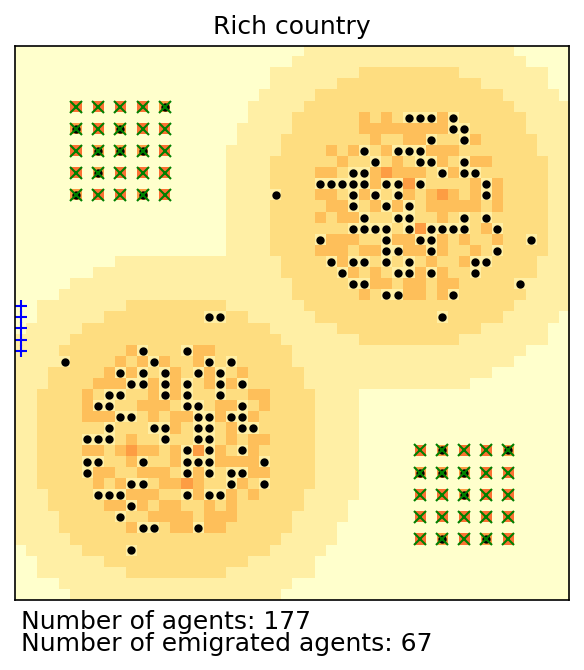

Number of agents in the poor country:  56
Number of agents in the rich country:  177


In [ ]:
trades = False
government = True
migration = False
emigrate = True

EMIGRATED_AGENTS = 0
NEW_EMIGRATED_AGENTS = 0
NEW_EMIGRATED_LIST = []

env1 = Sugarscape_poor(50, num_agents=300)
env2 = Sugarscape_rich(50, num_agents=300)

model = Model(env1, env2)

# run the model
list_agents_poor, list_agents_rich = model.animate(50, interval=0.1)
print("Number of agents in the poor country: ", env1.count_agents())
print("Number of agents in the rich country: ", env2.count_agents())

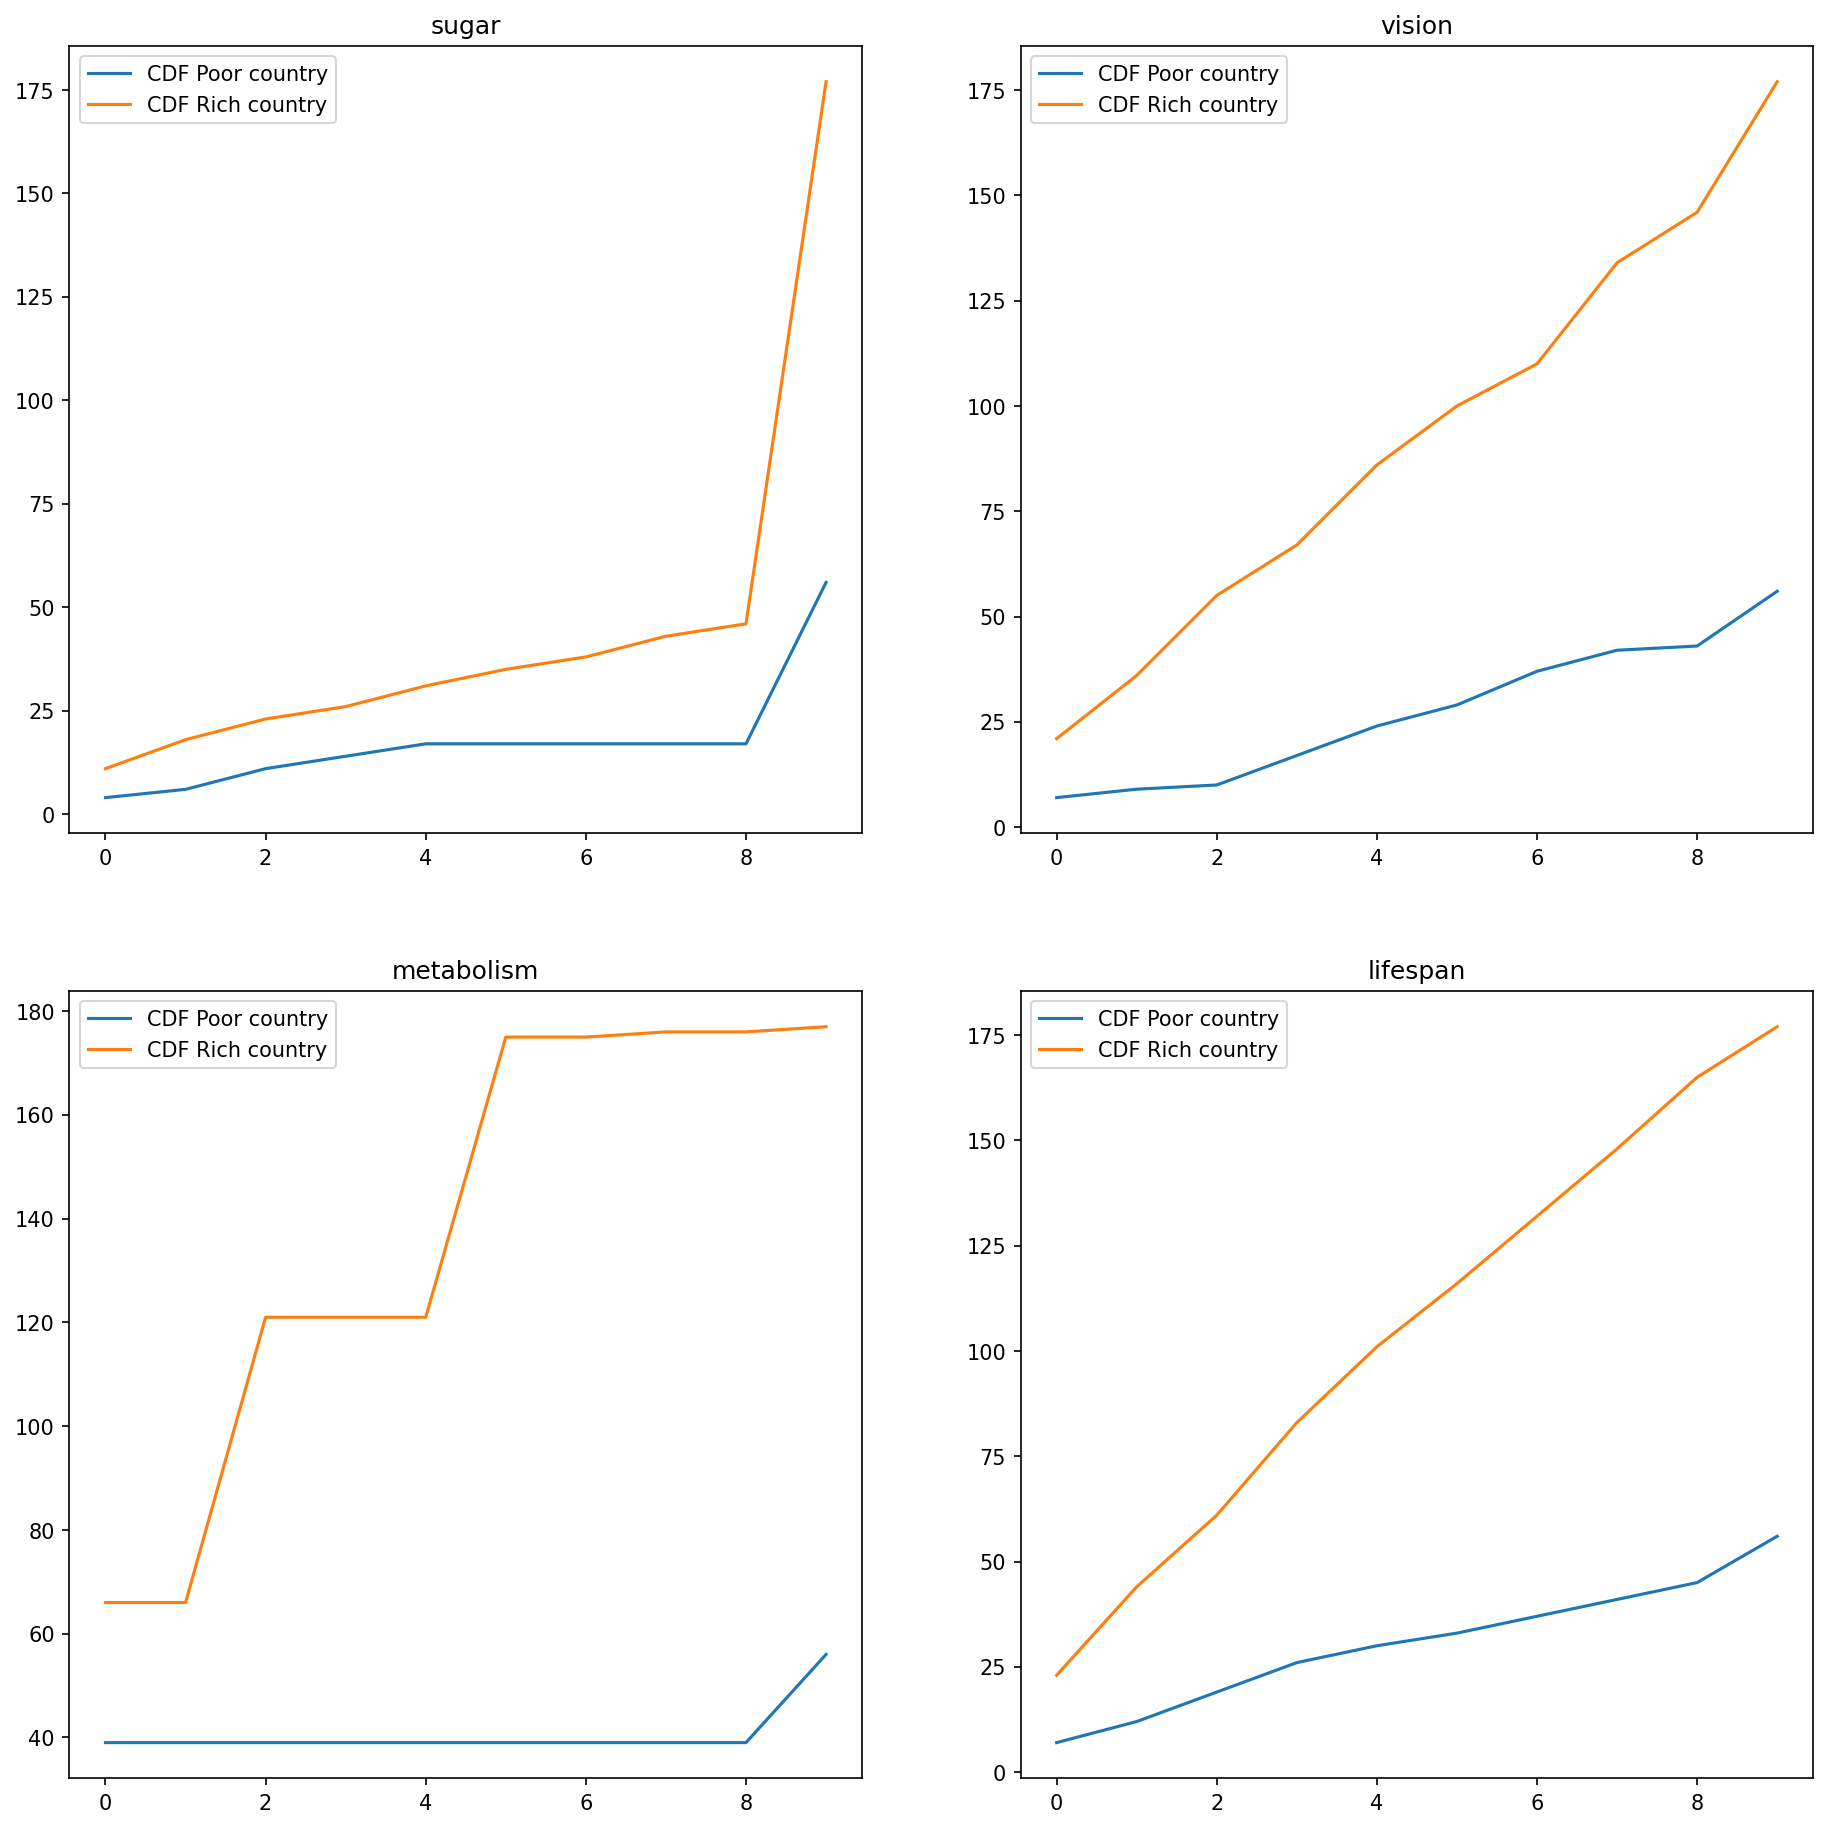

In [ ]:
if not trades:
    fig, axes = plt.subplots(2, 2, figsize=(15,15))
else:
    fig, axes = plt.subplots(4, 2, figsize=(15,15))

    end_sugar_poor = env1.get_sugar()
    end_spice_poor = env1.get_spice()

    end_sugar_rich = env2.get_sugar()
    end_spice_rich = env2.get_spice()

    met_sug_poor = env1.get_metabolism()
    met_spice_poor = env1.get_spice_met()

    met_sug_rich = env2.get_metabolism()
    met_spice_rich = env2.get_spice_met()


    wellfare_tot_poor = []
    for i in range(len(end_sugar_poor)):
        wellfare_tot_poor.append((end_sugar_poor[i]**(met_sug_poor[i]/ (met_sug_poor[i] + met_spice_poor[i]))) * (end_spice_poor[i]**(met_spice_poor[i] / (met_sug_poor[i] + met_spice_poor[i]))))

    wellfare_tot_rich = []
    for i in range(len(end_sugar_rich)):
        wellfare_tot_rich.append((end_sugar_rich[i]**(met_sug_rich[i]/ (met_sug_rich[i] + met_spice_rich[i]))) * (end_spice_rich[i]**(met_spice_rich[i] / (met_sug_rich[i] + met_spice_rich[i]))))


    count_poor, bins_count_poor = np.histogram(env1.get_spice())
    count_rich, bins_count_rich = np.histogram(env2.get_spice())
    pdf_poor = count_poor / sum(count_poor)
    pdf_rich = count_rich / sum(count_rich)
    cdf_poor = np.cumsum(count_poor)
    cdf_rich = np.cumsum(count_rich)
    axes[2, 0].plot(cdf_poor, label="CDF Poor country")
    axes[2, 0].plot(cdf_rich, label="CDF Rich country")
    axes[2, 0].set_title('spice')
    axes[2, 0].legend()


    count_poor, bins_count_poor = np.histogram(wellfare_tot_poor)
    count_rich, bins_count_rich = np.histogram(wellfare_tot_rich)
    pdf_poor = count_poor / sum(count_poor)
    pdf_rich = count_rich / sum(count_rich)
    cdf_poor = np.cumsum(count_poor)
    cdf_rich = np.cumsum(count_rich)
    axes[2, 1].plot(cdf_poor, label="CDF Poor country")
    axes[2, 1].plot(cdf_rich, label="CDF Rich country")
    axes[2, 1].set_title('wellfare')
    axes[2, 1].legend()

    count_poor, bins_count_poor = np.histogram(env1.get_spice_met())
    count_rich, bins_count_rich = np.histogram(env2.get_spice_met())
    pdf_poor = count_poor / sum(count_poor)
    pdf_rich = count_rich / sum(count_rich)
    cdf_poor = np.cumsum(count_poor)
    cdf_rich = np.cumsum(count_rich)
    axes[3, 0].plot(cdf_poor, label="CDF Poor country")
    axes[3, 0].plot(cdf_rich, label="CDF Rich country")
    axes[3, 0].set_title('spice metabolism')
    axes[3, 0].legend()


    sug_poor = env1.get_sugar()
    sug_rich = env2.get_sugar()
    sp_poor = env1.get_spice()
    sp_rich = env2.get_spice()
    endowment_poor = [sum(x) for x in zip(sug_poor, sp_poor)]
    endowment_rich = [sum(x) for x in zip(sug_rich, sp_rich)]
    count_poor, bins_count_poor = np.histogram(wellfare_tot_poor)
    count_rich, bins_count_rich = np.histogram(wellfare_tot_rich)
    pdf_poor = count_poor / sum(count_poor)
    pdf_rich = count_rich / sum(count_rich)
    cdf_poor = np.cumsum(count_poor)
    cdf_rich = np.cumsum(count_rich)
    axes[3, 1].plot(cdf_poor, label="CDF Poor country")
    axes[3, 1].plot(cdf_rich, label="CDF Rich country")
    axes[3, 1].set_title('total endowments')
    axes[3, 1].legend()

count_poor, bins_count_poor = np.histogram(env1.get_sugar())
count_rich, bins_count_rich = np.histogram(env2.get_sugar())
pdf_poor = count_poor / sum(count_poor)
pdf_rich = count_rich / sum(count_rich)
cdf_poor = np.cumsum(count_poor)
cdf_rich = np.cumsum(count_rich)
axes[0, 0].plot(cdf_poor, label="CDF Poor country")
axes[0, 0].plot(cdf_rich, label="CDF Rich country")
axes[0, 0].set_title('sugar')
axes[0, 0].legend()

count_poor, bins_count_poor = np.histogram(env1.get_vision())
count_rich, bins_count_rich = np.histogram(env2.get_vision())
pdf_poor = count_poor / sum(count_poor)
pdf_rich = count_rich / sum(count_rich)
cdf_poor = np.cumsum(count_poor)
cdf_rich = np.cumsum(count_rich)
axes[0, 1].plot(cdf_poor, label="CDF Poor country")
axes[0, 1].plot(cdf_rich, label="CDF Rich country")
axes[0, 1].set_title('vision')
axes[0, 1].legend()

count_poor, bins_count_poor = np.histogram(env1.get_metabolism())
count_rich, bins_count_rich = np.histogram(env2.get_metabolism())
pdf_poor = count_poor / sum(count_poor)
pdf_rich = count_rich / sum(count_rich)
cdf_poor = np.cumsum(count_poor)
cdf_rich = np.cumsum(count_rich)
axes[1, 0].plot(cdf_poor, label="CDF Poor country")
axes[1, 0].plot(cdf_rich, label="CDF Rich country")
axes[1, 0].set_title('metabolism')
axes[1, 0].legend()

count_poor, bins_count_poor = np.histogram(env1.get_lifespan())
count_rich, bins_count_rich = np.histogram(env2.get_lifespan())
pdf_poor = count_poor / sum(count_poor)
pdf_rich = count_rich / sum(count_rich)
cdf_poor = np.cumsum(count_poor)
cdf_rich = np.cumsum(count_rich)
axes[1, 1].plot(cdf_poor, label="CDF Poor country")
axes[1, 1].plot(cdf_rich, label="CDF Rich country")
axes[1, 1].set_title('lifespan')
axes[1, 1].legend()

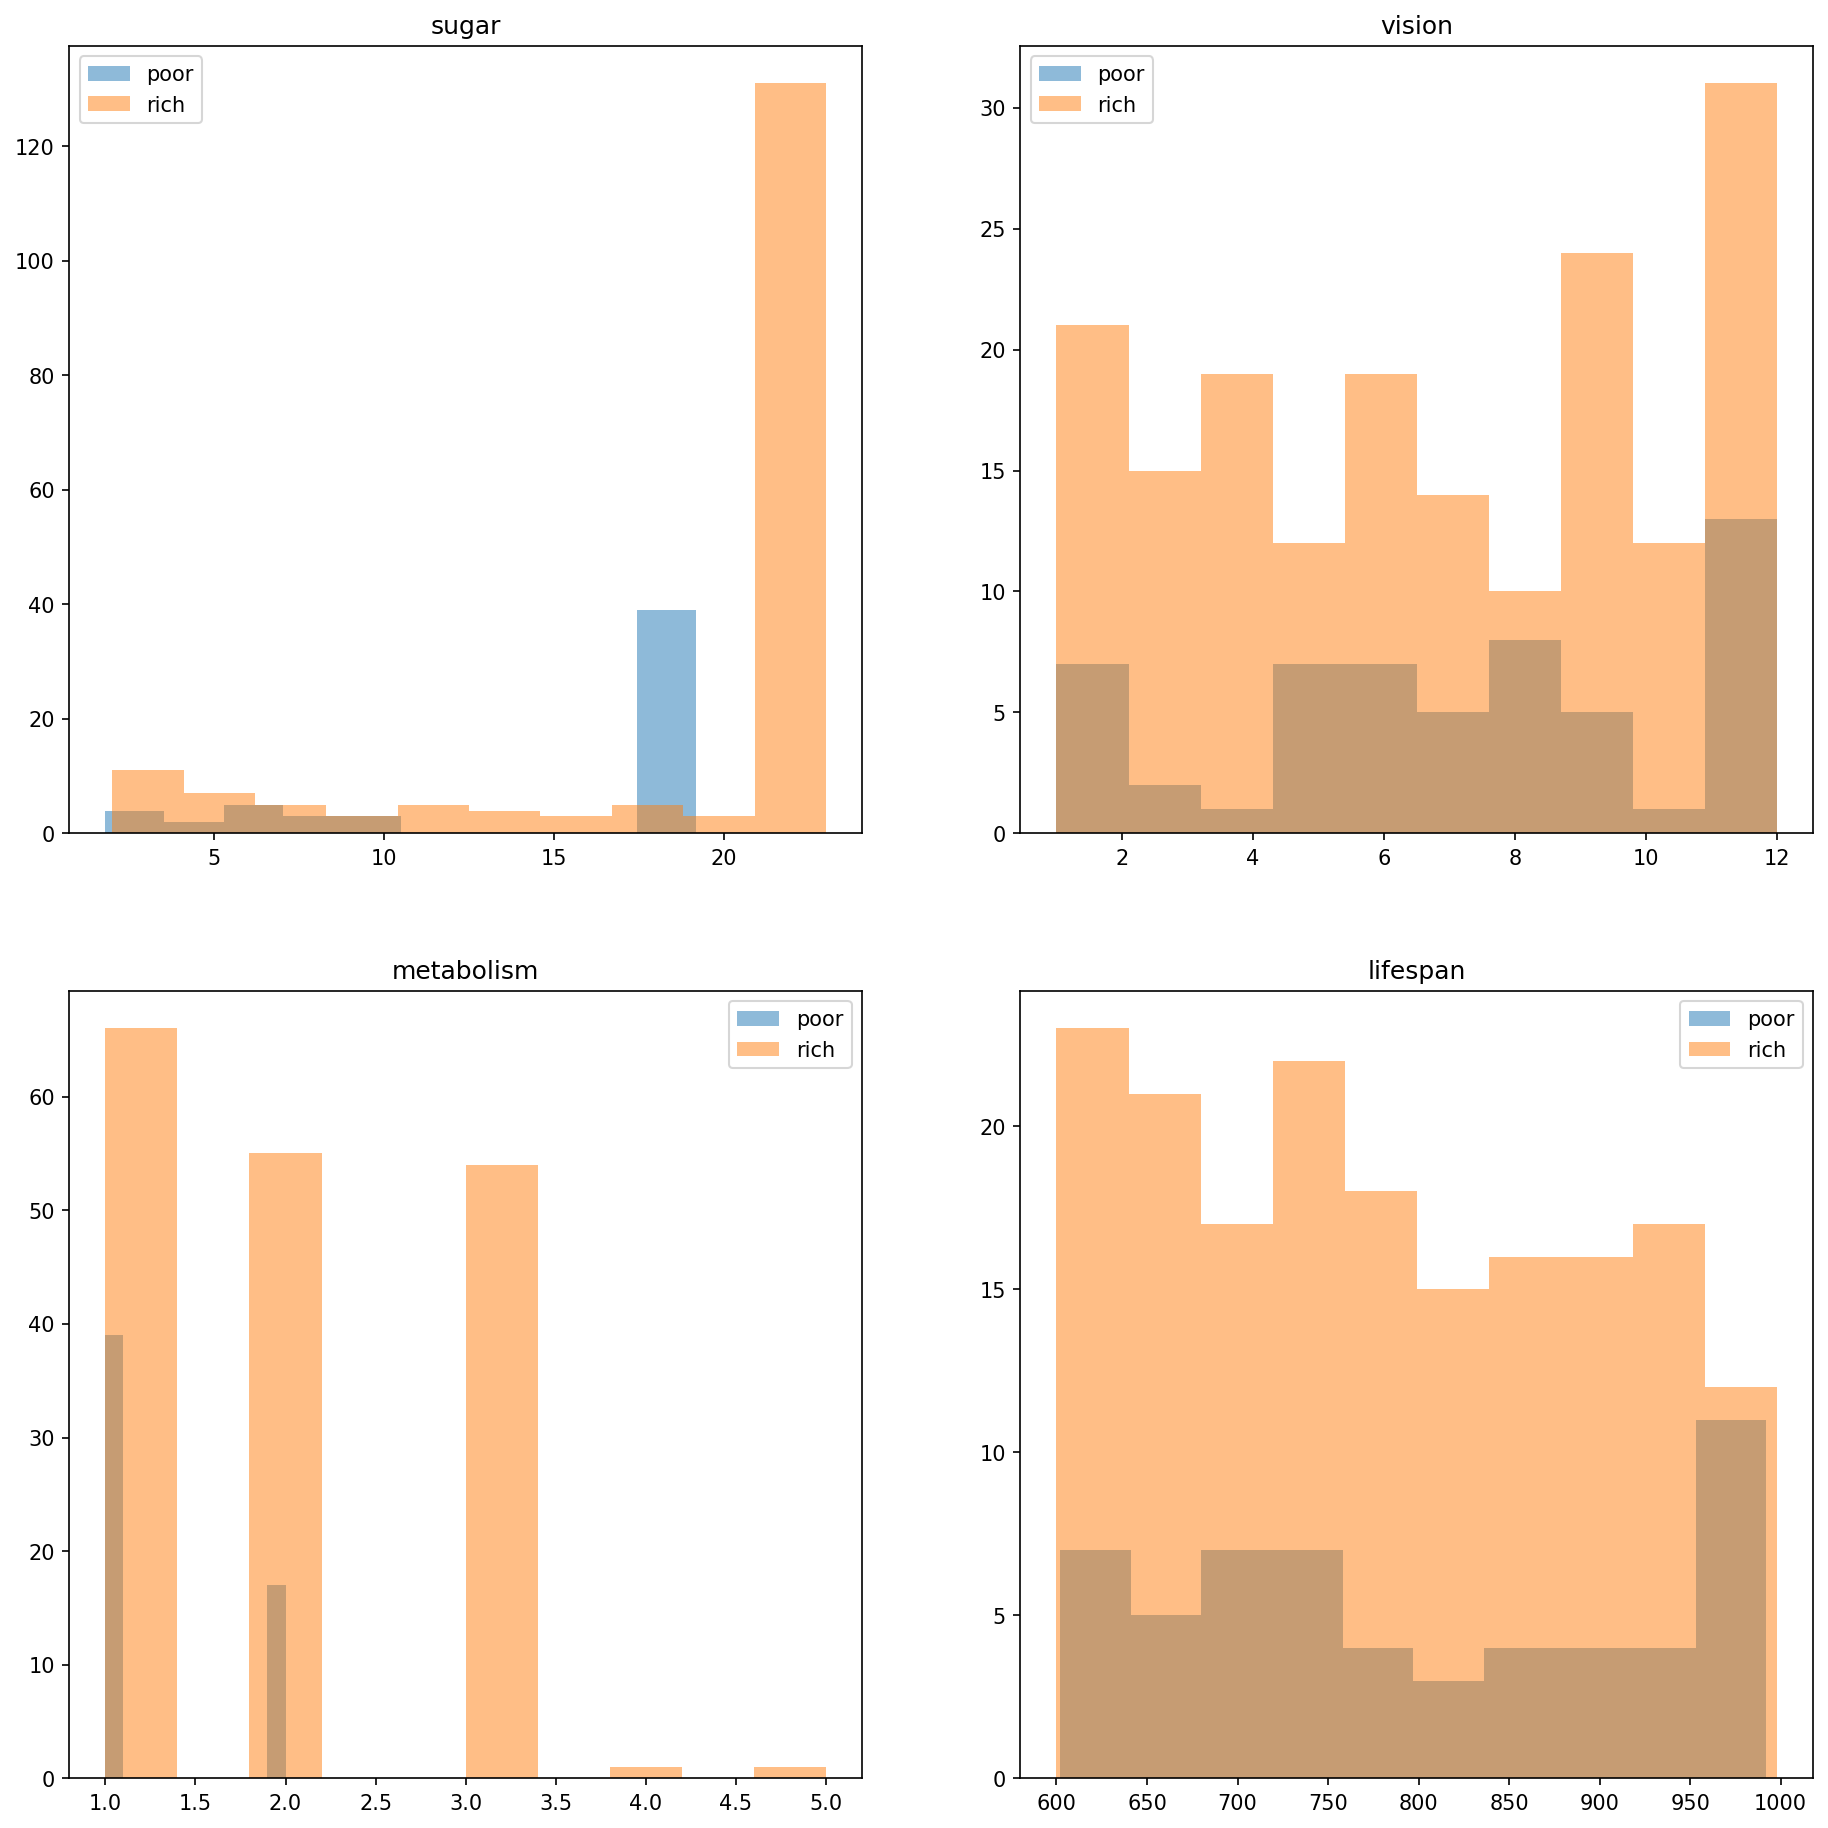

In [ ]:
if not trades:
    fig, axes = plt.subplots(2, 2, figsize=(15,15))
else:
    fig, axes = plt.subplots(4, 2, figsize=(15,15))
    axes[2, 0].hist(env1.get_sugar(), alpha=0.5)
    axes[2, 0].hist(env2.get_sugar(), alpha=0.5)
    axes[2, 0].set_title('spice')
    axes[2, 0].legend(['poor', 'rich'])

    axes[2, 1].hist(wellfare_tot_poor, alpha=0.5)
    axes[2, 1].hist(wellfare_tot_rich, alpha=0.5)
    axes[2, 1].set_title('wellfare')
    axes[2, 1].legend(['poor', 'rich'])

    axes[3, 0].hist(env1.get_spice_met(), alpha=0.5)
    axes[3, 0].hist(env2.get_spice_met(), alpha=0.5)
    axes[3, 0].set_title('spice metabolism')
    axes[3, 0].legend(['poor', 'rich'])

    axes[3, 1].hist(endowment_poor, alpha=0.5)
    axes[3, 1].hist(endowment_rich, alpha=0.5)
    axes[3, 1].set_title('total endowments')
    axes[3, 1].legend(['poor', 'rich'])

axes[0, 0].hist(env1.get_sugar(), alpha=0.5)
axes[0, 0].hist(env2.get_sugar(), alpha=0.5)
axes[0, 0].set_title('sugar')
axes[0, 0].legend(['poor', 'rich'])

axes[0, 1].hist(env1.get_vision(), alpha=0.5)
axes[0, 1].hist(env2.get_vision(), alpha=0.5)
axes[0, 1].set_title('vision')
axes[0, 1].legend(['poor', 'rich'])

axes[1, 0].hist(env1.get_metabolism(), alpha=0.5)
axes[1, 0].hist(env2.get_metabolism(), alpha=0.5)
axes[1, 0].set_title('metabolism')
axes[1, 0].legend(['poor', 'rich'])

axes[1, 1].hist(env1.get_lifespan(), alpha=0.5)
axes[1, 1].hist(env2.get_lifespan(), alpha=0.5)
axes[1, 1].set_title('lifespan')
axes[1, 1].legend(['poor', 'rich'])

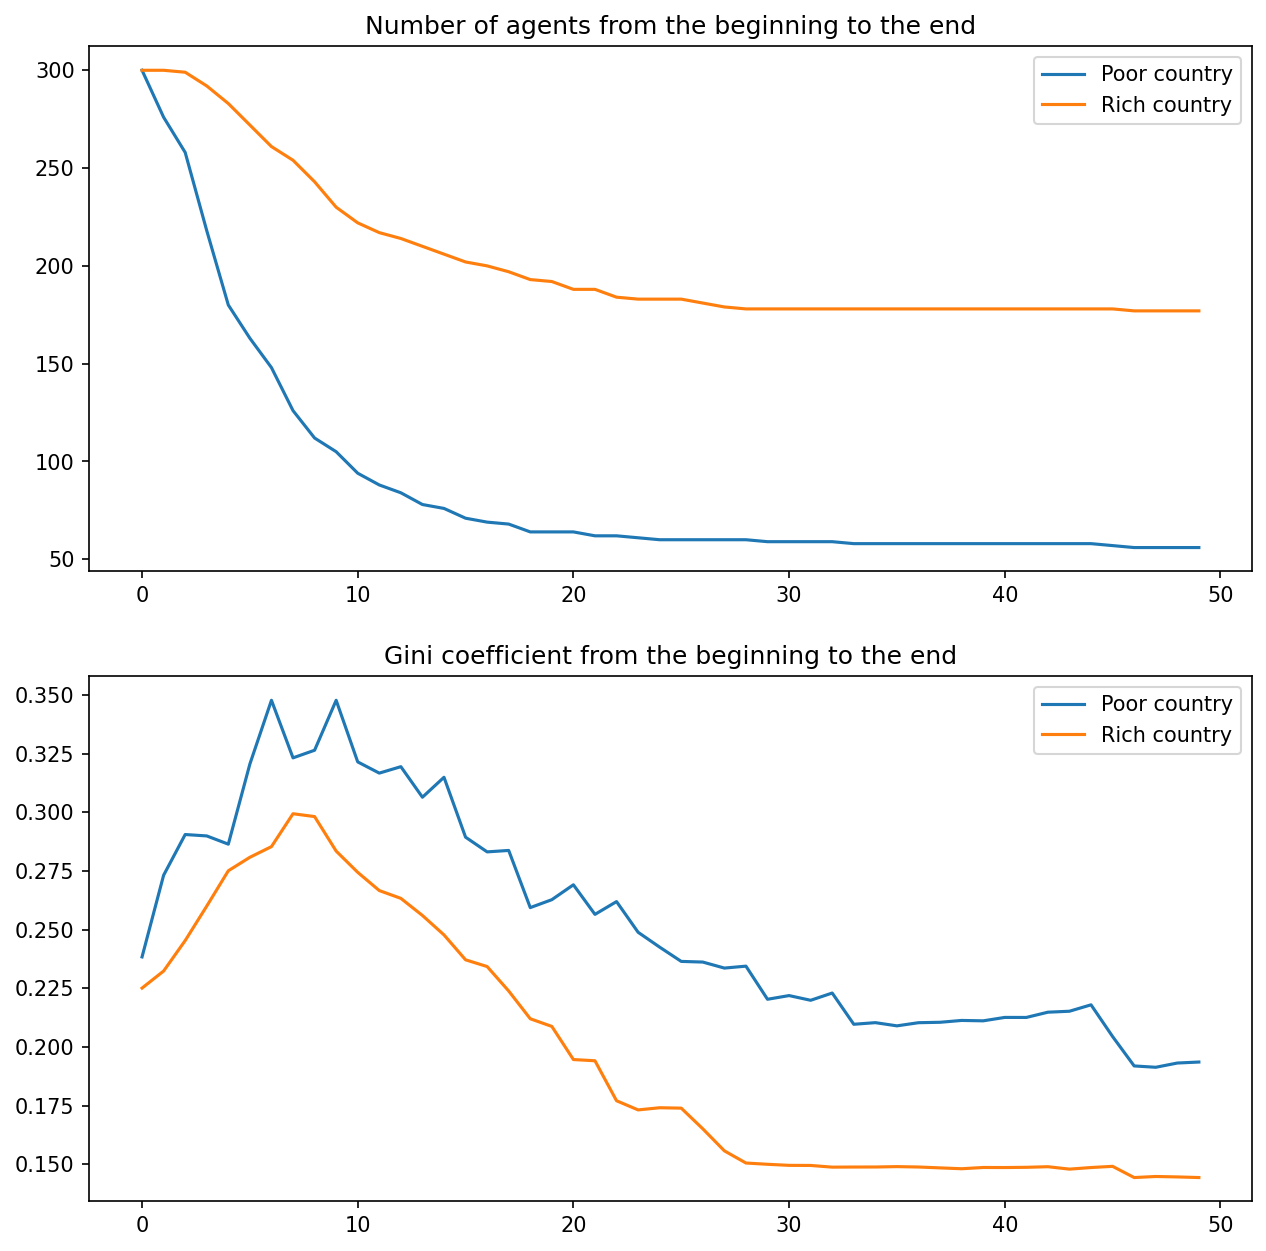

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (10,10))

ax1.plot(list_agents_poor[0])
ax1.plot(list_agents_rich[0])
ax1.set_title("Number of agents from the beginning to the end")
ax1.legend(["Poor country", "Rich country"])

ax2.plot(list_agents_poor[1])
ax2.plot(list_agents_rich[1])
ax2.set_title("Gini coefficient from the beginning to the end")
ax2.legend(["Poor country", "Rich country"])

In [ ]:
if trades:
    x_poor = []
    x_rich = []
    y_poor = []
    y_rich = []
    n_trades_poor = []
    n_trades_rich = []
    mean_poor = []
    mean_rich = []

    for i in list(list_agents_poor[2].keys()):
        n_trades_poor.append(len(list_agents_poor[2][i]))
        mean_poor.append(np.mean(list_agents_poor[2][i]))
        mean_poor = [0 if math.isnan(x) else x for x in mean_poor]

        for c in list_agents_poor[2][i]:
            x_poor.append(i)
            y_poor.append(c)


    for i in list(list_agents_rich[2].keys()):
        n_trades_rich.append(len(list_agents_rich[2][i]))
        mean_rich.append(np.mean(list_agents_rich[2][i]))

        for c in list_agents_rich[2][i]:
            x_rich.append(i)
            y_rich.append(c)

    fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(15,15))

    ax0.scatter(x_poor, y_poor, marker='1')
    ax0.scatter(x_rich, y_rich, marker='1')
    ax0.set_title("Plot every trade's price per cicle")
    ax0.legend(["Poor country", "Rich country"])

    ax1.plot(n_trades_poor)
    ax1.plot(n_trades_rich)
    ax1.set_title('number of trades per cicle')
    ax1.legend(["Poor country", "Rich country"])

    ax2.plot(mean_poor)
    ax2.plot(mean_rich)
    ax2.set_title('mean price of trades per cicle')
    ax2.legend(["Poor country", "Rich country"])

___

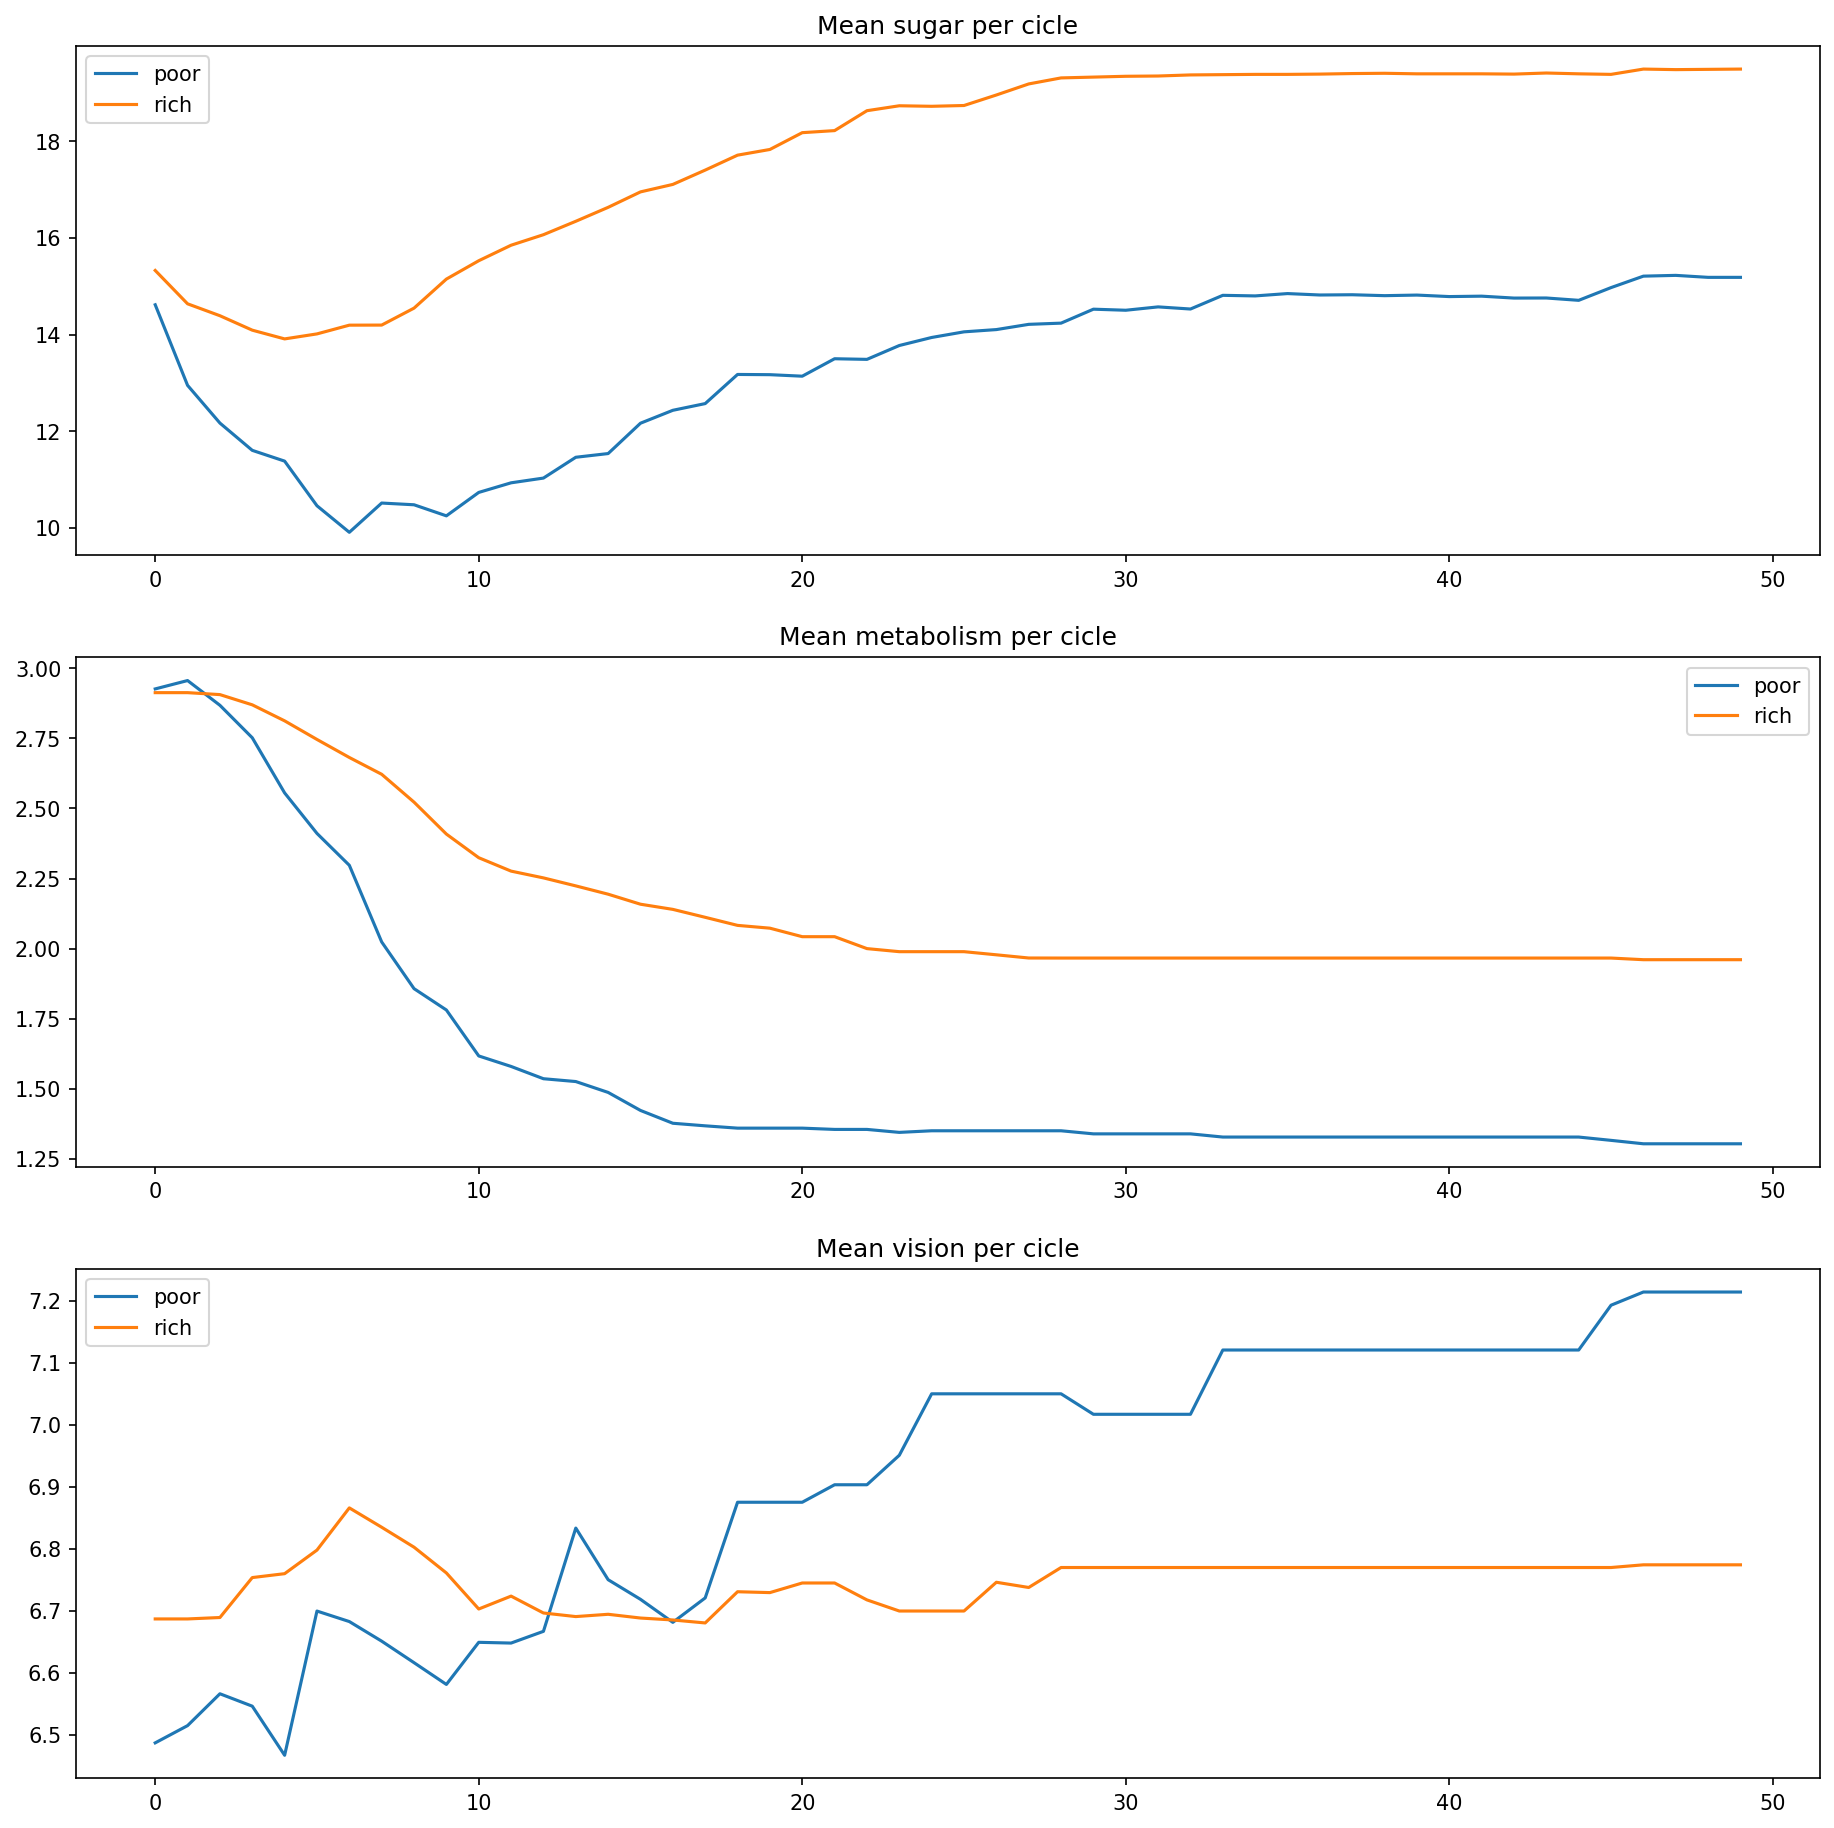

In [ ]:
if not trades:
    fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(15,15))

    ax0.plot(list_agents_poor[2])
    ax0.plot(list_agents_rich[2])
    ax0.set_title("Mean sugar per cicle")
    ax0.legend(['poor', 'rich'])

    ax1.plot(list_agents_poor[3])
    ax1.plot(list_agents_rich[3])
    ax1.set_title('Mean metabolism per cicle')
    ax1.legend(['poor', 'rich'])

    ax2.plot(list_agents_poor[4])
    ax2.plot(list_agents_rich[4])
    ax2.set_title('Mean vision per cicle')
    ax2.legend(['poor', 'rich'])

else:
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, figsize=(15,15))

    ax0.plot(list_agents_poor[3])
    ax0.plot(list_agents_rich[3])
    ax0.set_title("Mean sugar per cicle")
    ax0.legend(['poor', 'rich'])

    ax1.plot(list_agents_poor[4])
    ax1.plot(list_agents_rich[4])
    ax1.set_title('Mean metabolism per cicle')
    ax1.legend(['poor', 'rich'])

    ax2.plot(list_agents_poor[5])
    ax2.plot(list_agents_rich[5])
    ax2.set_title('Mean vision per cicle')
    ax2.legend(['poor', 'rich'])

    ax3.plot(list_agents_poor[6])
    ax3.plot(list_agents_rich[6])
    ax3.set_title('Mean spice per cicle')
    ax3.legend(['poor', 'rich'])

    ax4.plot(list_agents_poor[7])
    ax4.plot(list_agents_rich[7])
    ax4.set_title(' Mean spice metabolism per cicle')
    ax4.legend(['poor', 'rich'])